### Work through STAC catalog for RCM-ARD

In [1]:
%matplotlib inline

import os
import json
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from rich.table import Table

from pystac_client import Client
import stackstac

In [2]:
# Utility functions
def get_bbox(geojson_path):
    """Extracts bounding box coordinates from an input vector data file"""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple([float(b) for b in gdf.total_bounds])

    return bbox


def get_asset_resolutions(stac_item):
    """Extracts the pixel resolution of all GeoTIFF assets within a STAC item"""
    resolutions = {}
    asset_names = [k for k in stac_item.assets.keys() if stac_item.assets[k].href.endswith('.tif')]
    for asset in asset_names:
        tiff = stac_item.assets[asset].href
        with rio.open(tiff) as src:
            res = src.meta['transform'][0]
        resolutions[asset] = res

    return resolutions

#### Retrieve data within a specific bounding box and date range

In [3]:
# Use City of Ottawa urban boundary as test AOI
geojson_path = './ottawa_urban_boundary.geojson'
aoi_gdf = gpd.read_file(geojson_path)
utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()  # required for stackstac call
bbox = get_bbox(geojson_path)
bbox

(-75.96666401487873, 45.23090774120208, -75.43410167132566, 45.516074722660285)

In [4]:
# Filter assets by imaging date
start_date = '2025-01-01'
end_date = '2025-05-31'

In [5]:
# Open EODMS STAC catalog and explore available collections
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
collections = list(catalog.get_collections())

print(f"Number of collections: {len(collections)}")
print("Collection IDs:")
for collection in collections:
    print(f"- {collection.id}")

Number of collections: 3
Collection IDs:
- sentinel-1
- rcm-ard
- rcm


In [6]:
# Get RCM-ARD collection by ID and explore
collection = catalog.get_child('rcm-ard')
collection

<CollectionClient id=rcm-ard>

In [ ]:
# List all items in RCM-ARD collection that intersect with area of interest within date range
search = catalog.search(
    collections=['rcm-ard'],
    bbox=bbox,
    datetime=f'{start_date}/{end_date}',
    limit=100,
    method='GET'
)

items = search.item_collection()
print(f'{len(items)} products found')
for item in items:
    print(item.properties['title'])

21 products found
RCM1_OK3555463_PK3630004_1_SC30MCPB_20250530_225209_CH_CV_MLC
RCM1_OK3433415_PK3630003_1_SC30MCPB_20250530_225209_CH_CV_MLC
RCM2_OK3421269_PK3625031_1_SC30MCPD_20250527_110417_CH_CV_MLC
RCM2_OK3421254_PK3625030_1_SC30MCPD_20250527_110417_CH_CV_MLC
RCM2_OK3555463_PK3625035_1_SC30MCPD_20250527_110417_CH_CV_MLC
RCM2_OK3433415_PK3617458_1_SC30MCPA_20250521_224426_CH_CV_MLC
RCM2_OK3555463_PK3617459_1_SC30MCPA_20250521_224426_CH_CV_MLC
RCM1_OK3555463_PK3611612_1_SC30MCPB_20250517_224414_CH_CV_MLC
RCM3_OK3555463_PK3609219_1_SC30MCPD_20250515_230033_CH_CV_MLC
RCM3_OK3433415_PK3609218_1_SC30MCPD_20250515_230033_CH_CV_MLC
RCM1_OK3555463_PK3605341_1_SC30MCPB_20250513_112009_CH_CV_MLC
RCM2_OK3421269_PK3601645_1_SC30MCPC_20250510_225219_CH_CV_MLC
RCM2_OK3433415_PK3601650_1_SC30MCPC_20250510_225219_CH_CV_MLC
RCM2_OK3555463_PK3601651_1_SC30MCPC_20250510_225219_CH_CV_MLC
RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_CH_CV_MLC
RCM1_OK3433415_PK3563194_1_SC30MCPC_20250412_225206_

#### Filter and stack results

In [8]:
# Filter results by desired properties: looking for MLC products with 'CH', 'CV', and 'XC' polarizations
polarizations = ['CH', 'CV', 'XC']
product_type = 'MLC'
filtered_items = [x for x in items if x.properties['sar:polarizations'] == polarizations and x.properties['sar:product_type'] == product_type]

In [9]:
# Explore assets available in products: contains GeoTiff raster images along with metadata
asset_table = Table("Asset Key", "Description", 'Roles')
for asset_key, asset in filtered_items[0].assets.items():
    asset_table.add_row(asset_key, asset.title, str(asset.roles))

asset_table

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key               ┃ Description                                       ┃ Roles                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rl                      │ Backscatter Measurements RL Polarization          │ ['data', 'gamma()']               │
│ rr                      │ Backscatter Measurements RR Polarization          │ ['data', 'gamma()']               │
│ rrrl                    │ Normalized Polarimetric Radar Covariance Matrix   │ ['data', 'covmat']                │
│                         │ (CovMat)                                          │                                   │
│ metadata                │ ARD Product Metadata                              │ ['metadata']                      │
│ data_mask               │ Data Mask Image                                   │ ['data', 'data-mask']             │
│ thumbnail               │ Thumbnail                                         │ ['thumbnail']                     │
│ eula_license            │ EULA                                              │ ['license']                       │
│ rl_thumbnail            │ Backscatter RL Polarization Quicklook             │ None                              │
│ rr_thumbnail            │ Backscatter RR Polarization Quicklook             │ None                              │
│ local_inc_angle         │ Local Incident Angle Image                        │ ['data', 'local-incidence-angle'] │
│ gamma_to_sigma_ratio    │ Gamma-to-Sigma Ratio Image                        │ ['data']                          │
│ local_contributing_area │ Scattering Area Image                             │ ['data']                          │
└─────────────────────────┴───────────────────────────────────────────────────┴───────────────────────────────────┘

In [10]:
# Each data asset is stored in an AWS S3 bucket in cloud-optimized GeoTiff (COG) format
filtered_items[0].assets['rr'].to_dict()

{'href': 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/05/30/RCM1_OK3555463_PK3630004_1_SC30MCPB_20250530_225209_CH_CV_MLC/RCM1_OK3555463_PK3630004_1_SC30MCPB_20250530_225209_RR.tif',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'title': 'Backscatter Measurements RR Polarization',
 'roles': ['data', 'gamma()']}

In [11]:
# Check pixel resolution for each COG comprising our item
asset_resolutions = get_asset_resolutions(filtered_items[0])
asset_resolutions

{'rl': 20.0,
 'rr': 20.0,
 'rrrl': 20.0,
 'data_mask': 20.0,
 'rl_thumbnail': 200.10781671159032,
 'rr_thumbnail': 200.10781671159032,
 'local_inc_angle': 20.0,
 'gamma_to_sigma_ratio': 20.0,
 'local_contributing_area': 20.0}

In [12]:
# We can alternatively get data asset resolutions directly from the STAC item properties
resolution = (filtered_items[0].properties['product_row_spacing'], filtered_items[0].properties['product_column_spacing'])
resolution

(20.0, 20.0)

In [13]:
# Stack selected COG assets into a multi-band xarray DataArray with stackstac
stack = stackstac.stack(filtered_items,
                        assets=['rr', 'rl'],
                        bounds_latlon=bbox,  # only include pixels within our bounding box
                        resolution=resolution,
                        epsg=utm_crs
                       )
stack

<xarray.DataArray 'stackstac-35e220ac58f64d84e450dfed25524d17' (time: 21,
                                                                band: 2,
                                                                y: 1603, x: 2100)> Size: 1GB
dask.array<fetch_raster_window, shape=(21, 2, 1603, 2100), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/37)
  * time                           (time) datetime64[ns] 168B 2025-02-27T22:5...
    id                             (time) <U36 3kB '3c4151a9-3311-4ef5-917c-0...
  * band                           (band) <U2 16B 'rr' 'rl'
  * x                              (x) float64 17kB 4.241e+05 ... 4.661e+05
  * y                              (y) float64 13kB 5.041e+06 ... 5.009e+06
    processing:software            (time) object 168B {'RCM PGS': '7.06'} ......
    ...                             ...
    sar:frequency_band             <U1 4B 'C'
    sar:looks_range                int64 8B 2
    sar:product_type               <U3 12B 'MLC'
    sar:center_frequency           float64 8B 5.405
    sar:instrument_mode            <U21 84B 'Medium Resolution 30m'
    epsg                           int64 8B 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(424100.0, 5008680.0, 466100.0...
    crs:         epsg:32618
    transform:   | 20.00, 0.00, 424100.00|\n| 0.00,-20.00, 5040740.00|\n| 0.0...
    resolution:  20.0

### Data exploration

The `catalog.search()` function returns all items in the `rcm-ard` STAC collection that intersect with our bounding box extent.

These may not all have full coverage of the GeoJSON geometry of interest, but we can calculate the percent overlap of each from the DataArray object returned by `stackstac.stac()`

In [14]:
def aoi_coverage_table(gdf, raster_stack, asset_key):
    """Calculates coverage of a GeoDataFrame area of interest"""
    # Calculate totol area of geodataframe
    if gdf.crs.to_epsg() != stack.rio.crs.to_epsg():
        gdf = gdf.to_crs(stack.rio.crs)

    gdf_area = gdf.dissolve().geometry.area.sum()

    # Clip each raster in stack to AOI geometry
    dict_list = []
    resolution = stack.rio.resolution()[0]
    for scene in stack:
        asset_array = scene.sel(band=asset_key)
        asset_array_clip = asset_array.rio.clip(gdf.dissolve().geometry.values)

        # Count non-nodata pixels and calculate percent coverage
        valid_pixels = np.count_nonzero(~np.isnan(asset_array_clip.values))
        clipped_area = valid_pixels * resolution * resolution
        coverage_pct = round((clipped_area / gdf_area) * 100, 1)

        order_key = str(asset_array.coords['order_key'].values)
        dict_list.append({'order_key': order_key,
                          'coverage': coverage_pct})

    # Return table with results
    coverage_table = pd.DataFrame(dict_list).sort_values(by='coverage', ascending=False)

    return coverage_table    

In [15]:
coverage_table = aoi_coverage_table(aoi_gdf, stack, 'rr')
coverage_table

,order_key,coverage
4,RCM1_OK3433412_PK3563193_1_SC30MCPC_20250412_2...,100.0
10,RCM1_OK3555463_PK3605341_1_SC30MCPB_20250513_1...,100.0
8,RCM2_OK3421269_PK3601645_1_SC30MCPC_20250510_2...,100.0
7,RCM2_OK3555463_PK3601651_1_SC30MCPC_20250510_2...,100.0
5,RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_2...,100.0
6,RCM1_OK3433415_PK3563194_1_SC30MCPC_20250412_2...,96.1
9,RCM2_OK3433415_PK3601650_1_SC30MCPC_20250510_2...,95.8
11,RCM3_OK3433415_PK3609218_1_SC30MCPD_20250515_2...,67.7
19,RCM1_OK3555463_PK3630004_1_SC30MCPB_20250530_2...,40.2
20,RCM1_OK3433415_PK3630003_1_SC30MCPB_20250530_2...,40.2


We will filter our multidimensional `xarray.DataArray` to keep a single RCM image with highest coverage of our Ottawa AOI

In [16]:
order_key = coverage_table.iloc[0,0]
stack_filtered = stack[stack.coords['order_key'] == order_key][0,:,:]  # drop now-redundant time dimension

### Data manipulation with numpy and xarray

Raw SAR backscatter values are typically very skewed, so we will transform them from amplitude to decibels (dB) for visualization

In [17]:
stack_db = 10 * np.log10(stack_filtered)
stack_db = stack_db.assign_attrs(stack_filtered.attrs)  # rasterio attributes aren't always copied on arithmatic with xarray
stack_db.attrs['long_name'] = 'backscatter (dB)'

Exploring the value distribution of each polarization after converting to decibels:

In [18]:
def histogram_with_percentiles(rds, lower=2, upper=98):
    fig, axes = plt.subplots(ncols=rds.shape[0], figsize=(14, 6))
    for i, ax in enumerate(axes):
        # Plot basic histogram of values
        b = rds.isel(band=i)
        b.plot.hist(bins=50, ax=ax)
        band_name = str(rds.coords['title'][i].values)
        ax.set(title=band_name, xlabel='backscatter intensity (dB)', ylabel='pixel count')
        
        # Mark specified percentiles on plot
        pct_low = np.percentile(b.values, lower)
        pct_high = np.percentile(b.values, upper)
        ax.axvline(x=pct_low, color='purple', linestyle='--', label=f'{str(lower)}nd percentile: {str(round(pct_low, 2))}')
        ax.axvline(x=pct_high, color='red', linestyle='--', label=f'{str(upper)}th percentile: {str(round(pct_high, 2))}')
        ax.legend()

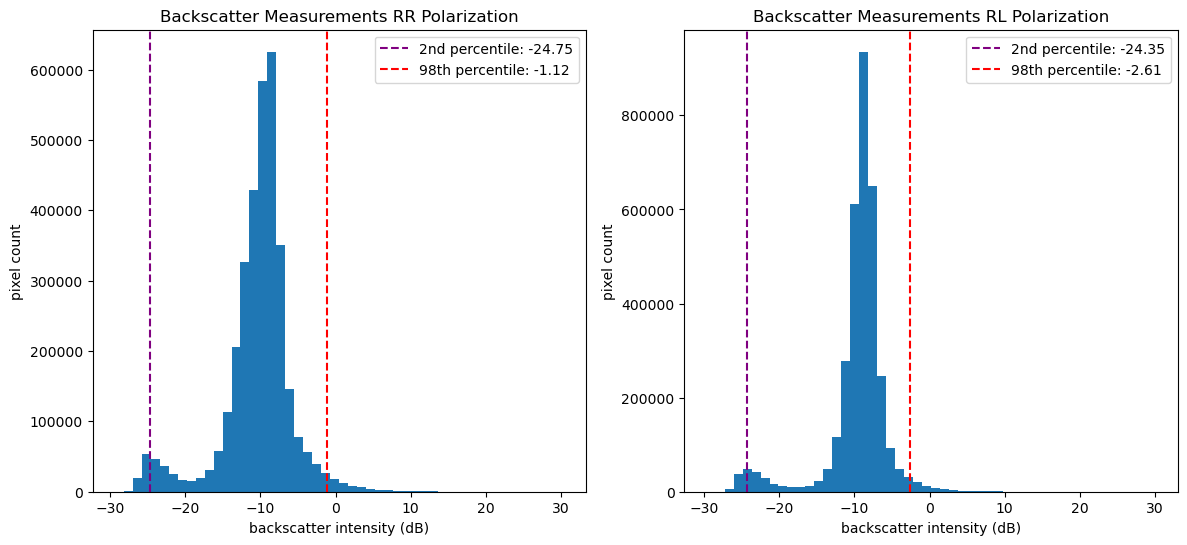

In [19]:
histogram_with_percentiles(stack_db)

We will apply a stretching function to pixel values to emphasize contrast based on percentiles:

In [20]:
def percent_stretch(rds, lower=2, upper=98):
    """Normalize each band in a DataArray using a percentile stretch"""
    stretched_bands = []
    for b in rds:
        pct_low = np.percentile(b.values, lower)
        pct_high = np.percentile(b.values, upper)
        stretched = np.clip(b.values, pct_low, pct_high)
        stretched_bands.append(stretched)

    # Rebuild array with new stretched values
    stretched_array = xr.DataArray(
        data=np.stack(stretched_bands),
        dims=rds.dims,
        coords=rds.coords,
        attrs=rds.attrs,
        name=rds.name
    )
    
    return stretched_array

In [21]:
pct_stretched = percent_stretch(stack_db)

### Data visualization

Plotting each polarization side-by-side after percentile stretching:

[Text(0.5, 1.0, 'RL Polarization')]

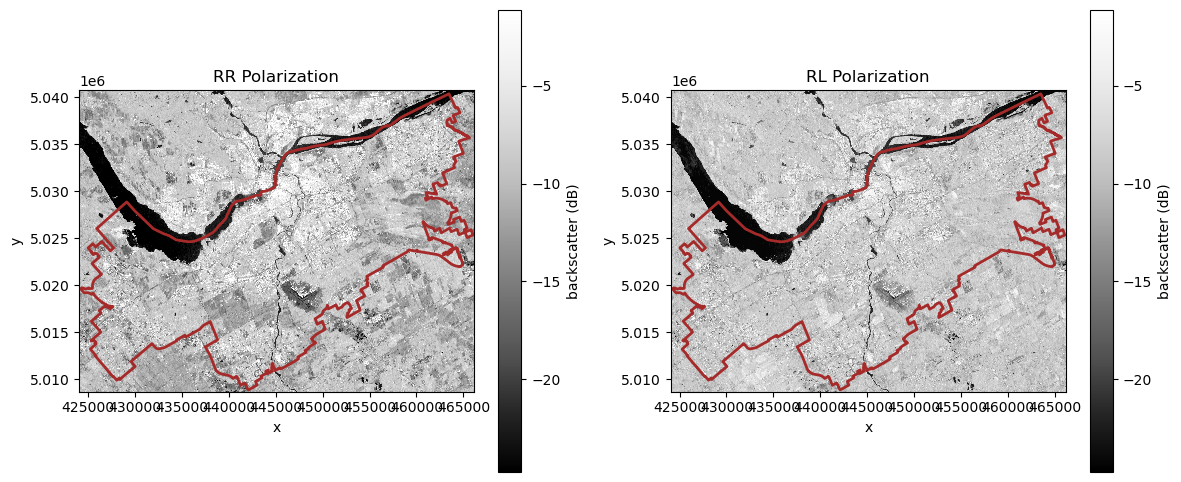

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
global_min, global_max = np.min(pct_stretched), np.max(pct_stretched)  # standardize colour ramping

pct_stretched.sel(band='rr').plot(ax=axes[0], cmap='Greys_r', vmin=global_min, vmax=global_max)
aoi_gdf.to_crs(utm_crs).plot(ax=axes[0], facecolor='none', edgecolor='brown', linewidth=2)
axes[0].set(title='RR Polarization')

pct_stretched.sel(band='rl').plot(ax=axes[1], cmap='Greys_r', vmin=global_min, vmax=global_max)
aoi_gdf.to_crs(utm_crs).plot(ax=axes[1], facecolor='none', edgecolor='brown', linewidth=2)
axes[1].set(title='RL Polarization')

### Exporting RCM-ARD data

The original ARD products can be directly downloaded from AWS S3 in COG format using Python libraries such as `requests`

In [23]:
# Downloading RR and RL polarizations along with the image's QA mask
filtered_item = [i for i in filtered_items if i.properties['order_key'] == order_key][0]
download_urls = filtered_item.assets['rl'].href, filtered_item.assets['rr'].href, filtered_item.assets['data_mask'].href

out_dir = './data'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [24]:
# Each individual raster file can be up to ~2GB in size
for url in download_urls:
    out_basename = Path(url).stem
    filename = f'{out_dir}/{out_basename}.tif'
    print(f'Downloading {out_basename}.tif to {out_dir}')
    
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

Derived products within `DataArrays` can also be saved to disk using the `.rio.to_raster()` method

In [25]:
# Exporting RR and RL polarizations within City of Ottawa bounding box after conversion to dB
for band in stack_db:
    basename = band.coords['order_key'].values
    polarization = str(band.coords['band'].values).upper()
    filename = f'{out_dir}/{basename}_{polarization}_clipped_db.tif'
    band.rio.to_raster(filename)
    print(f'Exported {filename} to disk')

Exported ./data/RCM1_OK3433412_PK3563193_1_SC30MCPC_20250412_225206_CH_CV_MLC_RR_clipped_db.tif to disk
Exported ./data/RCM1_OK3433412_PK3563193_1_SC30MCPC_20250412_225206_CH_CV_MLC_RL_clipped_db.tif to disk
